## Import packages you need


In [1]:
# Import necessary packages.
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, SubsetRandomSampler
from torchvision.datasets import DatasetFolder
from sklearn.model_selection import KFold

# If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm


/home/alex/miniconda3/envs/4016/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Show current device name


In [2]:
torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3080 Ti'

## Dataset, Data Loader, and Transforms


In [3]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    transforms.RandAugment(),

    # Randomly flip and rotate the image
    transforms.RandomRotation(degrees=10),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),


    # Randomly adjust the brightness and contrast of the image
    transforms.RandomCrop(size=128, padding=10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=(-10, 10, -10, 10)),

    # Convert the image to a tensor
    transforms.ToTensor(),
])

# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 96

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("../data/training/labeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("../data/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
unlabeled_set = DatasetFolder("../data/training/unlabeled", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
test_set = DatasetFolder("../data/testing", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


## Model

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.


## Training


In [4]:
def get_pseudo_labels(dataset, model, threshold=0.65):
    # This functions generates pseudo-labels of a dataset using given model.
    # It returns an instance of DatasetFolder containing images whose prediction confidences exceed a given threshold.
    # You are NOT allowed to use any models trained on external data for pseudo-labeling.
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Construct a data loader.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    # Make sure the model is in eval mode.
    model.eval()
    # Define softmax function.
    softmax = nn.Softmax(dim=-1)

    # Iterate over the dataset by batches.
    for batch in tqdm(dataloader):
        img, _ = batch

        # Forward the data
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(img.to(device))

        # Obtain the probability distributions by applying softmax on logits.
        probs = softmax(logits)

        # you may filter the data and construct a new dataset here.

    # # Turn off the eval mode.
    model.train()
    return dataset


In [5]:
def model_snapshot(model, new_file=None, old_file=None):
    if os.path.exists(old_file) is True:
        os.remove(old_file)
    torch.save(model, new_file)


In [6]:
def trainModel(model, n_epochs, do_semi, device, criterion, optimizer, train_loader, valid_loader):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    bestAcc = 0.
    bestEpoch = 0
    bestModel = None

    for epoch in range(n_epochs):
        # ---------- TODO ----------
        # In each epoch, relabel the unlabeled dataset for semi-supervised learning.
        # Then you can combine the labeled dataset and pseudo-labeled dataset for the training.
        if do_semi:
            # Obtain pseudo-labels for unlabeled data using trained model.
            pseudo_set = get_pseudo_labels(unlabeled_set, model, 0.95)

            # Construct a new dataset and a data loader for training.
            # This is used in semi-supervised learning only.
            concat_dataset = ConcatDataset([train_set, pseudo_set])
            train_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

        # ---------- Training ----------
        # Make sure the model is in train mode before training.
        model.train()

        # These are used to record information in training.
        train_loss = []
        train_accs = []

        # Iterate the training set by batches.
        for batch in tqdm(train_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # Forward the data. (Make sure data and model are on the same device.)
            logits = model(imgs.to(device))

            # Calculate the cross-entropy loss.
            # We don't need to apply softmax before computing cross-entropy as it is done automatically.
            loss = criterion(logits, labels.to(device))

            # Gradients stored in the parameters in the previous step should be cleared out first.
            optimizer.zero_grad()

            # Compute the gradients for parameters.
            loss.backward()

            # Clip the gradient norms for stable training.
            grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

            # Update the parameters with computed gradients.
            optimizer.step()

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            train_loss.append(loss.item())
            train_accs.append(acc)

        # The average loss and accuracy of the training set is the average of the recorded values.
        train_loss = sum(train_loss) / len(train_loss)
        train_acc = sum(train_accs) / len(train_accs)

        # Print the information.
        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        # ---------- Validation ----------
        # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
        model.eval()

        # These are used to record information in validation.
        valid_loss = []
        valid_accs = []

        # Iterate the validation set by batches.
        for batch in tqdm(valid_loader):

            # A batch consists of image data and corresponding labels.
            imgs, labels = batch

            # We don't need gradient in validation.
            # Using torch.no_grad() accelerates the forward process.
            with torch.no_grad():
                logits = model(imgs.to(device))

            # We can still compute the loss (but not the gradient).
            loss = criterion(logits, labels.to(device))

            # Compute the accuracy for current batch.
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

            # Record the loss and accuracy.
            valid_loss.append(loss.item())
            valid_accs.append(acc)

        # The average loss and accuracy for entire validation set is the average of the recorded values.
        valid_loss = sum(valid_loss) / len(valid_loss)
        valid_acc = sum(valid_accs) / len(valid_accs)

        # Print the information.
        print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")

        # Save the loss and accuracy for each epoch.
        history['train_loss'].append(train_loss)
        history['val_loss'].append(valid_loss)
        history['train_acc'].append(train_acc.cpu())
        history['val_acc'].append(valid_acc.cpu())

        # Dont ask, this is the only way to round the number for some reason
        if float(f"{valid_acc:.5f}") > float(f"{bestAcc:.5f}"):
            model_snapshot(model.state_dict(), new_file=f"{epoch + 1}_{valid_acc}.pth", old_file=f"{bestEpoch + 1}_{bestAcc}.pth")
            bestAcc = valid_acc
            bestEpoch = epoch
            bestModel = model

        if epoch - bestEpoch > 50:
            break

    # Return model and history for later use.
    return bestModel, history


In [7]:
def plotLoss(history):
    plt.plot([*range(1, len(history['train_loss']) + 1)], history['train_loss'])
    plt.plot([*range(1, len(history['val_loss']) + 1)], history['val_loss'])
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.legend(labels=['Train', 'Validation'])


In [8]:
def plotAcc(history):
    plt.plot([*range(1, len(history['train_acc']) + 1)], history['train_acc'])
    plt.plot([*range(1, len(history['val_acc']) + 1)], history['val_acc'])
    plt.xlabel("Epoches")
    plt.ylabel("Accuracy")
    plt.legend(labels=['Train', 'Validation'])


In [9]:
# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
# modelPath = "test.pth"
# model = torchvision.models.efficientnet_b6(weights=torchvision.models.EfficientNet_B6_Weights.DEFAULT).to(device)
model = torchvision.models.efficientnet_v2_m(weights=None).to(device)
# model.load_state_dict(torch.load(modelPath, map_location=device))
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# The number of training epochs.
n_epochs = 500

# Whether to do semi-supervised learning.
do_semi = False


In [10]:
bestdModel, history = trainModel(model, n_epochs, do_semi, device, criterion, optimizer, train_loader, valid_loader)
lastModel = model


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 001/500 ] loss = 6.61990, acc = 0.08755


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 001/500 ] loss = 6.29847, acc = 0.09120


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 002/500 ] loss = 3.69154, acc = 0.09772


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 002/500 ] loss = 3.08313, acc = 0.08992


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 003/500 ] loss = 2.53595, acc = 0.08651


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 003/500 ] loss = 2.46772, acc = 0.09332


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 004/500 ] loss = 2.48207, acc = 0.09707


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 004/500 ] loss = 2.42730, acc = 0.09800


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 005/500 ] loss = 2.45712, acc = 0.09563


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 005/500 ] loss = 2.42521, acc = 0.08631


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 006/500 ] loss = 2.45294, acc = 0.09390


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 006/500 ] loss = 2.41735, acc = 0.09673


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 007/500 ] loss = 2.44923, acc = 0.08998


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 007/500 ] loss = 2.39581, acc = 0.10927


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 008/500 ] loss = 2.43800, acc = 0.09995


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 008/500 ] loss = 2.41200, acc = 0.10013


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 009/500 ] loss = 2.43078, acc = 0.11329


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 009/500 ] loss = 2.43499, acc = 0.08610


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 010/500 ] loss = 2.44336, acc = 0.09936


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 010/500 ] loss = 2.41090, acc = 0.09715


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 011/500 ] loss = 2.43718, acc = 0.08482


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 011/500 ] loss = 2.38994, acc = 0.10629


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 012/500 ] loss = 2.41129, acc = 0.10303


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 012/500 ] loss = 2.40377, acc = 0.10119


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 013/500 ] loss = 2.41622, acc = 0.09241


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 013/500 ] loss = 2.38935, acc = 0.10736


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 014/500 ] loss = 2.40810, acc = 0.10526


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 014/500 ] loss = 2.36945, acc = 0.11713


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 015/500 ] loss = 2.40440, acc = 0.10179


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 015/500 ] loss = 2.37496, acc = 0.12755


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 016/500 ] loss = 2.40186, acc = 0.10422


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 016/500 ] loss = 2.37933, acc = 0.10544


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 017/500 ] loss = 2.39190, acc = 0.11835


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 017/500 ] loss = 2.35742, acc = 0.12968


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 018/500 ] loss = 2.39999, acc = 0.11334


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 018/500 ] loss = 2.36994, acc = 0.13116


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 019/500 ] loss = 2.40303, acc = 0.11478


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 019/500 ] loss = 2.36434, acc = 0.12670


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 020/500 ] loss = 2.39206, acc = 0.11324


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 020/500 ] loss = 2.37581, acc = 0.12309


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 021/500 ] loss = 2.37986, acc = 0.12733


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 021/500 ] loss = 2.32834, acc = 0.13924


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 022/500 ] loss = 2.39013, acc = 0.10754


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 022/500 ] loss = 2.36155, acc = 0.12266


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 023/500 ] loss = 2.39650, acc = 0.10322


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 023/500 ] loss = 2.36241, acc = 0.11820


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 024/500 ] loss = 2.39561, acc = 0.11047


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 024/500 ] loss = 2.36425, acc = 0.13223


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 025/500 ] loss = 2.38038, acc = 0.11443


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 025/500 ] loss = 2.32965, acc = 0.12139


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 026/500 ] loss = 2.37959, acc = 0.11974


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 026/500 ] loss = 2.31286, acc = 0.15625


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 027/500 ] loss = 2.38019, acc = 0.11404


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 027/500 ] loss = 2.33082, acc = 0.13095


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 028/500 ] loss = 2.37218, acc = 0.12272


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 028/500 ] loss = 2.31404, acc = 0.14860


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 029/500 ] loss = 2.37317, acc = 0.12922


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 029/500 ] loss = 2.33723, acc = 0.14923


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 030/500 ] loss = 2.36936, acc = 0.13333


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 030/500 ] loss = 2.30028, acc = 0.18219


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 031/500 ] loss = 2.36130, acc = 0.13185


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 031/500 ] loss = 2.26383, acc = 0.20111


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 032/500 ] loss = 2.33369, acc = 0.15992


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 032/500 ] loss = 2.22491, acc = 0.23384


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 033/500 ] loss = 2.34132, acc = 0.15471


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 033/500 ] loss = 2.22088, acc = 0.21492


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 034/500 ] loss = 2.32150, acc = 0.16305


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 034/500 ] loss = 2.28842, acc = 0.20876


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 035/500 ] loss = 2.31338, acc = 0.16935


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 035/500 ] loss = 2.22927, acc = 0.19494


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 036/500 ] loss = 2.31605, acc = 0.16141


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 036/500 ] loss = 2.23766, acc = 0.21450


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 037/500 ] loss = 2.31059, acc = 0.16528


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 037/500 ] loss = 2.18747, acc = 0.23491


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 038/500 ] loss = 2.27147, acc = 0.17718


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 038/500 ] loss = 2.14376, acc = 0.25000


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 039/500 ] loss = 2.27730, acc = 0.17783


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 039/500 ] loss = 2.10730, acc = 0.24766


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 040/500 ] loss = 2.23645, acc = 0.20833


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 040/500 ] loss = 2.20762, acc = 0.22109


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 041/500 ] loss = 2.25868, acc = 0.18646


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 041/500 ] loss = 2.20474, acc = 0.20451


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 042/500 ] loss = 2.24652, acc = 0.20303


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 042/500 ] loss = 2.05188, acc = 0.26786


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 043/500 ] loss = 2.21843, acc = 0.21860


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 043/500 ] loss = 2.15411, acc = 0.24086


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 044/500 ] loss = 2.18876, acc = 0.21607


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 044/500 ] loss = 2.11241, acc = 0.22853


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 045/500 ] loss = 2.22138, acc = 0.20858


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 045/500 ] loss = 2.04438, acc = 0.27296


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 046/500 ] loss = 2.18245, acc = 0.21865


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 046/500 ] loss = 2.06608, acc = 0.26169


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 047/500 ] loss = 2.17523, acc = 0.21225


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 047/500 ] loss = 1.94183, acc = 0.31122


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 048/500 ] loss = 2.13537, acc = 0.22887


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 048/500 ] loss = 2.15579, acc = 0.26488


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 049/500 ] loss = 2.15278, acc = 0.23239


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 049/500 ] loss = 2.18739, acc = 0.25553


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 050/500 ] loss = 2.12379, acc = 0.23284


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 050/500 ] loss = 1.95291, acc = 0.31718


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 051/500 ] loss = 2.09805, acc = 0.26488


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 051/500 ] loss = 2.09885, acc = 0.23767


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 052/500 ] loss = 2.10950, acc = 0.25159


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 052/500 ] loss = 2.17553, acc = 0.26573


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 053/500 ] loss = 2.10786, acc = 0.24509


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 053/500 ] loss = 1.90379, acc = 0.31356


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 054/500 ] loss = 2.06128, acc = 0.26994


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 054/500 ] loss = 1.90923, acc = 0.30166


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 055/500 ] loss = 2.07833, acc = 0.25709


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 055/500 ] loss = 1.97980, acc = 0.29443


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 056/500 ] loss = 2.05393, acc = 0.27421


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 056/500 ] loss = 1.98213, acc = 0.31314


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 057/500 ] loss = 2.03956, acc = 0.27297


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 057/500 ] loss = 1.88779, acc = 0.34099


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 058/500 ] loss = 2.01789, acc = 0.27326


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 058/500 ] loss = 2.03756, acc = 0.29592


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 059/500 ] loss = 2.00888, acc = 0.28730


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 059/500 ] loss = 1.88419, acc = 0.32951


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 060/500 ] loss = 1.99101, acc = 0.29628


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 060/500 ] loss = 2.37610, acc = 0.23406


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 061/500 ] loss = 1.97023, acc = 0.30645


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 061/500 ] loss = 1.78873, acc = 0.36628


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 062/500 ] loss = 1.96432, acc = 0.30020


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 062/500 ] loss = 1.73720, acc = 0.36713


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 063/500 ] loss = 1.95243, acc = 0.30308


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 063/500 ] loss = 1.81770, acc = 0.35714


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 064/500 ] loss = 1.93922, acc = 0.31270


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 064/500 ] loss = 1.74062, acc = 0.37330


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 065/500 ] loss = 1.90866, acc = 0.32961


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 065/500 ] loss = 1.85498, acc = 0.35098


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 066/500 ] loss = 1.90701, acc = 0.33304


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 066/500 ] loss = 1.89998, acc = 0.35565


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 067/500 ] loss = 1.92239, acc = 0.32391


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 067/500 ] loss = 1.89207, acc = 0.33291


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 068/500 ] loss = 1.89040, acc = 0.33145


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 068/500 ] loss = 1.81781, acc = 0.37968


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 069/500 ] loss = 1.88370, acc = 0.34499


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 069/500 ] loss = 1.73624, acc = 0.36501


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 070/500 ] loss = 1.84333, acc = 0.34559


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 070/500 ] loss = 1.68688, acc = 0.41263


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 071/500 ] loss = 1.84251, acc = 0.34792


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 071/500 ] loss = 1.83190, acc = 0.38776


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 072/500 ] loss = 1.85671, acc = 0.33953


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 072/500 ] loss = 1.79874, acc = 0.37500


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 073/500 ] loss = 1.80616, acc = 0.36736


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 073/500 ] loss = 1.66441, acc = 0.43686


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 074/500 ] loss = 1.79155, acc = 0.37202


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 074/500 ] loss = 1.71985, acc = 0.37946


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 075/500 ] loss = 1.79041, acc = 0.37649


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 075/500 ] loss = 1.77202, acc = 0.39137


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 076/500 ] loss = 1.81839, acc = 0.36567


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 076/500 ] loss = 1.70351, acc = 0.43155


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 077/500 ] loss = 1.79354, acc = 0.36895


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 077/500 ] loss = 1.63543, acc = 0.42304


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 078/500 ] loss = 1.73413, acc = 0.39563


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 078/500 ] loss = 1.70396, acc = 0.37670


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 079/500 ] loss = 1.74571, acc = 0.39325


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 079/500 ] loss = 1.67234, acc = 0.41964


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 080/500 ] loss = 1.72160, acc = 0.39792


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 080/500 ] loss = 1.59557, acc = 0.43389


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 081/500 ] loss = 1.74156, acc = 0.38150


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 081/500 ] loss = 1.76897, acc = 0.40880


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 082/500 ] loss = 1.73803, acc = 0.39727


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 082/500 ] loss = 1.54493, acc = 0.46237


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 083/500 ] loss = 1.68193, acc = 0.41820


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 083/500 ] loss = 1.59543, acc = 0.44813


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 084/500 ] loss = 1.67291, acc = 0.40531


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 084/500 ] loss = 1.57698, acc = 0.44579


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 085/500 ] loss = 1.68134, acc = 0.41181


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 085/500 ] loss = 1.61031, acc = 0.44855


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 086/500 ] loss = 1.70365, acc = 0.41453


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 086/500 ] loss = 1.57740, acc = 0.43793


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 087/500 ] loss = 1.64777, acc = 0.42386


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 087/500 ] loss = 1.56857, acc = 0.45918


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 088/500 ] loss = 1.67422, acc = 0.41746


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 088/500 ] loss = 1.60681, acc = 0.44898


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 089/500 ] loss = 1.61058, acc = 0.44271


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 089/500 ] loss = 1.60007, acc = 0.45387


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 090/500 ] loss = 1.61751, acc = 0.43413


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 090/500 ] loss = 1.59030, acc = 0.46025


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 091/500 ] loss = 1.63775, acc = 0.42867


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 091/500 ] loss = 1.52672, acc = 0.47258


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 092/500 ] loss = 1.59093, acc = 0.43824


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 092/500 ] loss = 1.54163, acc = 0.47555


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 093/500 ] loss = 1.61377, acc = 0.44861


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 093/500 ] loss = 1.46140, acc = 0.49235


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 094/500 ] loss = 1.56731, acc = 0.44618


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 094/500 ] loss = 1.52865, acc = 0.48661


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 095/500 ] loss = 1.56347, acc = 0.45313


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 095/500 ] loss = 1.62921, acc = 0.44154


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 096/500 ] loss = 1.58237, acc = 0.45536


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 096/500 ] loss = 1.52302, acc = 0.48023


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 097/500 ] loss = 1.59456, acc = 0.44668


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 097/500 ] loss = 1.45588, acc = 0.50829


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 098/500 ] loss = 1.52890, acc = 0.46766


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 098/500 ] loss = 1.41918, acc = 0.49235


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 099/500 ] loss = 1.54521, acc = 0.47207


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 099/500 ] loss = 1.50033, acc = 0.47874


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 100/500 ] loss = 1.50921, acc = 0.48383


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 100/500 ] loss = 1.41621, acc = 0.49957


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 101/500 ] loss = 1.52635, acc = 0.47778


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 101/500 ] loss = 1.41062, acc = 0.52891


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 102/500 ] loss = 1.46755, acc = 0.49380


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 102/500 ] loss = 1.35122, acc = 0.53104


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 103/500 ] loss = 1.46684, acc = 0.48125


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 103/500 ] loss = 1.41120, acc = 0.51913


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 104/500 ] loss = 1.50285, acc = 0.48026


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 104/500 ] loss = 1.43389, acc = 0.51382


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 105/500 ] loss = 1.47229, acc = 0.49325


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 105/500 ] loss = 1.43426, acc = 0.50808


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 106/500 ] loss = 1.46949, acc = 0.49658


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 106/500 ] loss = 1.41715, acc = 0.50191


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 107/500 ] loss = 1.46208, acc = 0.48978


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 107/500 ] loss = 1.35383, acc = 0.54464


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 108/500 ] loss = 1.47448, acc = 0.49727


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 108/500 ] loss = 1.42738, acc = 0.48597


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 109/500 ] loss = 1.44629, acc = 0.50580


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 109/500 ] loss = 1.33811, acc = 0.53508


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 110/500 ] loss = 1.45112, acc = 0.50526


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 110/500 ] loss = 1.32363, acc = 0.55527


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 111/500 ] loss = 1.45137, acc = 0.49970


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 111/500 ] loss = 1.36781, acc = 0.53827


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 112/500 ] loss = 1.41584, acc = 0.51086


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 112/500 ] loss = 1.39669, acc = 0.52594


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 113/500 ] loss = 1.38552, acc = 0.52723


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 113/500 ] loss = 1.39510, acc = 0.52126


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 114/500 ] loss = 1.35680, acc = 0.54028


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 114/500 ] loss = 1.39157, acc = 0.53827


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 115/500 ] loss = 1.41584, acc = 0.51111


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 115/500 ] loss = 1.28208, acc = 0.54401


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 116/500 ] loss = 1.38433, acc = 0.52986


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 116/500 ] loss = 1.34706, acc = 0.55889


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 117/500 ] loss = 1.32876, acc = 0.54742


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 117/500 ] loss = 1.35400, acc = 0.54613


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 118/500 ] loss = 1.35693, acc = 0.54504


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 118/500 ] loss = 1.32594, acc = 0.54974


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 119/500 ] loss = 1.30889, acc = 0.55089


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 119/500 ] loss = 1.33137, acc = 0.55123


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 120/500 ] loss = 1.36994, acc = 0.54608


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 120/500 ] loss = 1.27926, acc = 0.56952


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 121/500 ] loss = 1.32664, acc = 0.55149


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 121/500 ] loss = 1.30045, acc = 0.55591


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 122/500 ] loss = 1.28143, acc = 0.56166


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 122/500 ] loss = 1.26688, acc = 0.57440


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 123/500 ] loss = 1.32523, acc = 0.55327


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 123/500 ] loss = 1.23744, acc = 0.57313


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 124/500 ] loss = 1.29309, acc = 0.54861


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 124/500 ] loss = 1.29717, acc = 0.57462


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 125/500 ] loss = 1.30969, acc = 0.54985


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 125/500 ] loss = 1.36855, acc = 0.53125


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 126/500 ] loss = 1.28371, acc = 0.55575


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 126/500 ] loss = 1.35644, acc = 0.56548


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 127/500 ] loss = 1.25773, acc = 0.57922


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 127/500 ] loss = 1.26209, acc = 0.57249


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 128/500 ] loss = 1.28331, acc = 0.55957


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 128/500 ] loss = 1.30226, acc = 0.56909


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 129/500 ] loss = 1.25089, acc = 0.56860


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 129/500 ] loss = 1.18745, acc = 0.58121


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 130/500 ] loss = 1.26455, acc = 0.57470


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 130/500 ] loss = 1.16247, acc = 0.62543


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 131/500 ] loss = 1.21161, acc = 0.58934


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 131/500 ] loss = 1.17758, acc = 0.60544


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 132/500 ] loss = 1.26294, acc = 0.56746


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 132/500 ] loss = 1.18010, acc = 0.61076


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 133/500 ] loss = 1.25760, acc = 0.57614


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 133/500 ] loss = 1.17953, acc = 0.59906


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 134/500 ] loss = 1.18536, acc = 0.60813


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 134/500 ] loss = 1.19467, acc = 0.60459


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 135/500 ] loss = 1.21348, acc = 0.58834


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 135/500 ] loss = 1.14522, acc = 0.63287


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 136/500 ] loss = 1.22972, acc = 0.57941


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 136/500 ] loss = 1.19969, acc = 0.58270


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 137/500 ] loss = 1.20153, acc = 0.58398


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 137/500 ] loss = 1.13640, acc = 0.60523


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 138/500 ] loss = 1.18458, acc = 0.58909


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 138/500 ] loss = 1.25872, acc = 0.56845


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 139/500 ] loss = 1.20639, acc = 0.59613


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 139/500 ] loss = 1.23628, acc = 0.60395


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 140/500 ] loss = 1.19570, acc = 0.59633


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 140/500 ] loss = 1.17168, acc = 0.61331


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 141/500 ] loss = 1.12733, acc = 0.61399


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 141/500 ] loss = 1.19931, acc = 0.59545


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 142/500 ] loss = 1.18614, acc = 0.60213


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 142/500 ] loss = 1.30063, acc = 0.56080


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 143/500 ] loss = 1.15147, acc = 0.59504


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 143/500 ] loss = 1.12459, acc = 0.63244


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 144/500 ] loss = 1.12577, acc = 0.62961


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 144/500 ] loss = 1.14525, acc = 0.62861


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 145/500 ] loss = 1.11930, acc = 0.61845


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 145/500 ] loss = 1.15049, acc = 0.62266


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 146/500 ] loss = 1.14037, acc = 0.61746


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 146/500 ] loss = 1.13603, acc = 0.62564


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 147/500 ] loss = 1.15944, acc = 0.60759


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 147/500 ] loss = 1.20500, acc = 0.59566


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 148/500 ] loss = 1.09523, acc = 0.62490


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 148/500 ] loss = 1.11051, acc = 0.62160


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 149/500 ] loss = 1.09771, acc = 0.62371


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 149/500 ] loss = 1.12202, acc = 0.60480


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 150/500 ] loss = 1.05945, acc = 0.64514


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 150/500 ] loss = 1.17017, acc = 0.63967


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 151/500 ] loss = 1.07262, acc = 0.63869


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 151/500 ] loss = 1.12438, acc = 0.62904


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 152/500 ] loss = 1.06783, acc = 0.64400


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 152/500 ] loss = 1.15112, acc = 0.64838


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 153/500 ] loss = 1.05180, acc = 0.64633


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 153/500 ] loss = 1.12640, acc = 0.61522


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 154/500 ] loss = 1.07826, acc = 0.63879


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 154/500 ] loss = 1.30404, acc = 0.56250


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 155/500 ] loss = 1.04766, acc = 0.64246


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 155/500 ] loss = 1.06847, acc = 0.63648


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 156/500 ] loss = 1.04395, acc = 0.64995


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 156/500 ] loss = 1.04361, acc = 0.63797


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 157/500 ] loss = 1.00856, acc = 0.65843


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 157/500 ] loss = 1.08709, acc = 0.63499


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 158/500 ] loss = 1.02564, acc = 0.65833


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 158/500 ] loss = 1.21713, acc = 0.58737


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 159/500 ] loss = 1.01834, acc = 0.66319


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 159/500 ] loss = 1.04620, acc = 0.64923


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 160/500 ] loss = 1.04560, acc = 0.64792


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 160/500 ] loss = 1.11585, acc = 0.64753


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 161/500 ] loss = 1.04214, acc = 0.65055


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 161/500 ] loss = 1.22820, acc = 0.59566


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 162/500 ] loss = 0.96912, acc = 0.67128


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 162/500 ] loss = 1.07010, acc = 0.65115


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 163/500 ] loss = 0.97867, acc = 0.67609


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 163/500 ] loss = 1.07253, acc = 0.64796


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 164/500 ] loss = 0.98711, acc = 0.67138


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 164/500 ] loss = 1.08294, acc = 0.64435


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 165/500 ] loss = 1.00490, acc = 0.66280


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 165/500 ] loss = 1.15351, acc = 0.63393


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 166/500 ] loss = 1.00731, acc = 0.65977


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 166/500 ] loss = 1.11411, acc = 0.62202


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 167/500 ] loss = 0.95340, acc = 0.67674


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 167/500 ] loss = 1.08732, acc = 0.63776


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 168/500 ] loss = 0.97773, acc = 0.67297


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 168/500 ] loss = 1.08057, acc = 0.66773


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 169/500 ] loss = 0.97212, acc = 0.67817


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 169/500 ] loss = 1.13706, acc = 0.62904


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 170/500 ] loss = 0.92087, acc = 0.69549


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 170/500 ] loss = 1.06912, acc = 0.63797


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 171/500 ] loss = 0.95822, acc = 0.67857


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 171/500 ] loss = 1.08801, acc = 0.62628


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 172/500 ] loss = 0.94026, acc = 0.67609


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 172/500 ] loss = 1.07028, acc = 0.63563


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 173/500 ] loss = 0.93774, acc = 0.68309


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 173/500 ] loss = 1.06722, acc = 0.63967


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 174/500 ] loss = 0.94078, acc = 0.68641


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 174/500 ] loss = 1.12319, acc = 0.63393


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 175/500 ] loss = 0.89003, acc = 0.69916


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 175/500 ] loss = 1.16611, acc = 0.63712


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 176/500 ] loss = 0.86770, acc = 0.70853


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 176/500 ] loss = 1.22662, acc = 0.60969


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 177/500 ] loss = 0.89443, acc = 0.69916


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 177/500 ] loss = 1.06174, acc = 0.65753


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 178/500 ] loss = 0.89727, acc = 0.69201


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 178/500 ] loss = 1.01989, acc = 0.67730


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 179/500 ] loss = 0.87506, acc = 0.70337


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 179/500 ] loss = 1.04414, acc = 0.65859


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 180/500 ] loss = 0.89467, acc = 0.70799


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 180/500 ] loss = 1.11384, acc = 0.64137


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 181/500 ] loss = 0.92695, acc = 0.68596


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 181/500 ] loss = 1.12468, acc = 0.64796


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 182/500 ] loss = 0.85777, acc = 0.71567


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 182/500 ] loss = 1.02893, acc = 0.67793


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 183/500 ] loss = 0.84737, acc = 0.71890


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 183/500 ] loss = 1.04503, acc = 0.64753


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 184/500 ] loss = 0.85385, acc = 0.71131


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 184/500 ] loss = 1.03370, acc = 0.67113


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 185/500 ] loss = 0.86496, acc = 0.70843


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 185/500 ] loss = 1.11843, acc = 0.64477


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 186/500 ] loss = 0.83105, acc = 0.72951


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 186/500 ] loss = 1.14961, acc = 0.63074


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 187/500 ] loss = 0.84021, acc = 0.72004


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 187/500 ] loss = 1.09548, acc = 0.66369


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 188/500 ] loss = 0.85832, acc = 0.71280


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 188/500 ] loss = 1.01879, acc = 0.65816


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 189/500 ] loss = 0.84336, acc = 0.72088


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 189/500 ] loss = 0.99712, acc = 0.68622


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 190/500 ] loss = 0.81638, acc = 0.73224


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 190/500 ] loss = 1.10813, acc = 0.64690


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 191/500 ] loss = 0.78243, acc = 0.73601


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 191/500 ] loss = 1.03078, acc = 0.66199


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 192/500 ] loss = 0.83359, acc = 0.72024


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 192/500 ] loss = 1.04009, acc = 0.67751


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 193/500 ] loss = 0.78408, acc = 0.73735


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 193/500 ] loss = 1.05591, acc = 0.66199


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 194/500 ] loss = 0.78307, acc = 0.73204


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 194/500 ] loss = 1.13769, acc = 0.64116


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 195/500 ] loss = 0.79815, acc = 0.73562


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 195/500 ] loss = 1.12689, acc = 0.65051


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 196/500 ] loss = 0.80393, acc = 0.72679


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 196/500 ] loss = 1.07543, acc = 0.66412


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 197/500 ] loss = 0.76080, acc = 0.74707


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 197/500 ] loss = 1.09985, acc = 0.65625


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 198/500 ] loss = 0.79779, acc = 0.73006


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 198/500 ] loss = 1.17043, acc = 0.63457


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 199/500 ] loss = 0.79615, acc = 0.73115


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 199/500 ] loss = 1.04006, acc = 0.69111


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 200/500 ] loss = 0.73749, acc = 0.75000


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 200/500 ] loss = 1.01827, acc = 0.67751


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 201/500 ] loss = 0.77978, acc = 0.72842


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 201/500 ] loss = 1.03638, acc = 0.68197


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 202/500 ] loss = 0.75529, acc = 0.74633


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 202/500 ] loss = 1.00466, acc = 0.66858


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 203/500 ] loss = 0.75576, acc = 0.75064


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 203/500 ] loss = 1.05844, acc = 0.66305


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 204/500 ] loss = 0.71719, acc = 0.75918


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 204/500 ] loss = 1.09288, acc = 0.67177


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 205/500 ] loss = 0.73174, acc = 0.75650


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 205/500 ] loss = 1.19412, acc = 0.64583


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 206/500 ] loss = 0.73823, acc = 0.75878


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 206/500 ] loss = 1.10239, acc = 0.63648


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 207/500 ] loss = 0.70668, acc = 0.76076


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 207/500 ] loss = 1.06142, acc = 0.68197


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 208/500 ] loss = 0.71878, acc = 0.75322


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 208/500 ] loss = 1.20383, acc = 0.63946


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 209/500 ] loss = 0.74028, acc = 0.75169


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 209/500 ] loss = 1.12882, acc = 0.65753


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 210/500 ] loss = 0.74134, acc = 0.74886


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 210/500 ] loss = 1.09760, acc = 0.66730


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 211/500 ] loss = 0.69888, acc = 0.76786


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 211/500 ] loss = 1.07215, acc = 0.66071


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 212/500 ] loss = 0.68597, acc = 0.77480


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 212/500 ] loss = 1.06880, acc = 0.67878


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 213/500 ] loss = 0.69489, acc = 0.76870


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 213/500 ] loss = 1.04734, acc = 0.67304


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 214/500 ] loss = 0.70326, acc = 0.77411


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 214/500 ] loss = 1.04180, acc = 0.66241


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 215/500 ] loss = 0.64597, acc = 0.77773


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 215/500 ] loss = 1.12488, acc = 0.64179


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 216/500 ] loss = 0.70914, acc = 0.76086


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 216/500 ] loss = 1.17132, acc = 0.64881


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 217/500 ] loss = 0.68984, acc = 0.76012


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 217/500 ] loss = 1.09030, acc = 0.64435


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 218/500 ] loss = 0.68071, acc = 0.77158


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 218/500 ] loss = 1.03005, acc = 0.68559


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 219/500 ] loss = 0.65367, acc = 0.78209


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 219/500 ] loss = 1.15034, acc = 0.64371


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 220/500 ] loss = 0.67154, acc = 0.77426


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 220/500 ] loss = 1.09074, acc = 0.65497


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 221/500 ] loss = 0.66930, acc = 0.77158


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 221/500 ] loss = 1.00008, acc = 0.70748


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 222/500 ] loss = 0.63453, acc = 0.78011


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 222/500 ] loss = 1.16036, acc = 0.66008


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 223/500 ] loss = 0.69323, acc = 0.77827


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 223/500 ] loss = 0.97587, acc = 0.70026


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 224/500 ] loss = 0.59043, acc = 0.80437


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 224/500 ] loss = 1.01013, acc = 0.69813


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 225/500 ] loss = 0.63589, acc = 0.78457


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 225/500 ] loss = 1.04577, acc = 0.68750


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 226/500 ] loss = 0.60759, acc = 0.79390


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 226/500 ] loss = 1.12906, acc = 0.67623


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 227/500 ] loss = 0.61732, acc = 0.80040


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 227/500 ] loss = 1.06513, acc = 0.68282


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 228/500 ] loss = 0.64819, acc = 0.78328


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 228/500 ] loss = 1.09241, acc = 0.66773


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 229/500 ] loss = 0.63920, acc = 0.78318


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 229/500 ] loss = 1.08818, acc = 0.66709


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 230/500 ] loss = 0.63594, acc = 0.78651


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 230/500 ] loss = 0.98862, acc = 0.67389


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 231/500 ] loss = 0.60242, acc = 0.79449


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 231/500 ] loss = 1.05493, acc = 0.67517


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 232/500 ] loss = 0.60459, acc = 0.79544


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 232/500 ] loss = 1.18019, acc = 0.64987


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 233/500 ] loss = 0.59280, acc = 0.80248


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 233/500 ] loss = 1.13075, acc = 0.68240


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 234/500 ] loss = 0.63875, acc = 0.79420


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 234/500 ] loss = 1.02199, acc = 0.70238


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 235/500 ] loss = 0.59773, acc = 0.80486


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 235/500 ] loss = 1.01053, acc = 0.69643


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 236/500 ] loss = 0.58208, acc = 0.80332


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 236/500 ] loss = 1.09470, acc = 0.66369


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 237/500 ] loss = 0.58827, acc = 0.80491


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 237/500 ] loss = 1.11365, acc = 0.67730


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 238/500 ] loss = 0.60317, acc = 0.80074


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 238/500 ] loss = 1.03800, acc = 0.69452


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 239/500 ] loss = 0.59592, acc = 0.79742


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 239/500 ] loss = 1.27737, acc = 0.63265


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 240/500 ] loss = 0.55242, acc = 0.80878


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 240/500 ] loss = 1.08341, acc = 0.69409


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 241/500 ] loss = 0.58168, acc = 0.81057


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 241/500 ] loss = 1.08886, acc = 0.69473


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 242/500 ] loss = 0.61339, acc = 0.79048


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 242/500 ] loss = 1.09980, acc = 0.68835


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 243/500 ] loss = 0.51764, acc = 0.83105


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 243/500 ] loss = 1.12471, acc = 0.68622


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 244/500 ] loss = 0.57280, acc = 0.81076


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 244/500 ] loss = 1.16678, acc = 0.65710


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 245/500 ] loss = 0.57153, acc = 0.81280


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 245/500 ] loss = 0.99774, acc = 0.72683


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 246/500 ] loss = 0.55662, acc = 0.80575


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 246/500 ] loss = 1.07063, acc = 0.68878


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 247/500 ] loss = 0.55625, acc = 0.81359


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 247/500 ] loss = 1.10860, acc = 0.67730


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 248/500 ] loss = 0.56083, acc = 0.81572


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 248/500 ] loss = 1.07001, acc = 0.68856


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 249/500 ] loss = 0.59739, acc = 0.79742


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 249/500 ] loss = 1.02646, acc = 0.67602


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 250/500 ] loss = 0.55242, acc = 0.81711


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 250/500 ] loss = 1.01246, acc = 0.69622


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 251/500 ] loss = 0.52419, acc = 0.83457


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 251/500 ] loss = 1.10979, acc = 0.69090


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 252/500 ] loss = 0.55931, acc = 0.81354


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 252/500 ] loss = 1.11783, acc = 0.70089


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 253/500 ] loss = 0.49919, acc = 0.84529


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 253/500 ] loss = 1.12622, acc = 0.67389


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 254/500 ] loss = 0.48913, acc = 0.83423


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 254/500 ] loss = 1.01990, acc = 0.70940


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 255/500 ] loss = 0.49983, acc = 0.83606


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 255/500 ] loss = 1.14917, acc = 0.67071


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 256/500 ] loss = 0.53317, acc = 0.81801


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 256/500 ] loss = 1.06891, acc = 0.69855


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 257/500 ] loss = 0.56631, acc = 0.81503


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 257/500 ] loss = 1.16856, acc = 0.65816


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 258/500 ] loss = 0.54502, acc = 0.82247


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 258/500 ] loss = 1.05261, acc = 0.66433


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 259/500 ] loss = 0.53112, acc = 0.82178


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 259/500 ] loss = 1.14122, acc = 0.65264


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 260/500 ] loss = 0.52567, acc = 0.82192


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 260/500 ] loss = 1.17050, acc = 0.68027


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 261/500 ] loss = 0.51546, acc = 0.83596


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 261/500 ] loss = 1.02829, acc = 0.69537


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 262/500 ] loss = 0.49436, acc = 0.84489


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 262/500 ] loss = 1.08406, acc = 0.67028


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 263/500 ] loss = 0.54125, acc = 0.82138


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 263/500 ] loss = 1.21510, acc = 0.64753


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 264/500 ] loss = 0.50445, acc = 0.82594


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 264/500 ] loss = 1.06127, acc = 0.69919


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 265/500 ] loss = 0.45974, acc = 0.84539


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 265/500 ] loss = 1.11803, acc = 0.69409


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 266/500 ] loss = 0.47008, acc = 0.84410


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 266/500 ] loss = 1.06112, acc = 0.70217


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 267/500 ] loss = 0.44031, acc = 0.85615


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 267/500 ] loss = 1.04268, acc = 0.70472


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 268/500 ] loss = 0.45624, acc = 0.84688


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 268/500 ] loss = 1.12517, acc = 0.69515


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 269/500 ] loss = 0.48457, acc = 0.83358


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 269/500 ] loss = 1.10280, acc = 0.69430


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 270/500 ] loss = 0.49012, acc = 0.84792


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 270/500 ] loss = 1.08243, acc = 0.69260


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 271/500 ] loss = 0.46593, acc = 0.83993


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 271/500 ] loss = 1.17779, acc = 0.66943


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 272/500 ] loss = 0.44145, acc = 0.85079


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 272/500 ] loss = 1.15804, acc = 0.69940


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 273/500 ] loss = 0.46792, acc = 0.84514


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 273/500 ] loss = 1.14297, acc = 0.68878


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 274/500 ] loss = 0.44065, acc = 0.85213


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 274/500 ] loss = 1.08593, acc = 0.70727


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 275/500 ] loss = 0.45817, acc = 0.84816


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 275/500 ] loss = 1.14519, acc = 0.69069


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 276/500 ] loss = 0.50216, acc = 0.83775


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 276/500 ] loss = 1.08528, acc = 0.69154


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 277/500 ] loss = 0.43886, acc = 0.86131


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 277/500 ] loss = 1.15406, acc = 0.69069


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 278/500 ] loss = 0.46510, acc = 0.85233


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 278/500 ] loss = 1.05162, acc = 0.69133


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 279/500 ] loss = 0.44539, acc = 0.85258


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 279/500 ] loss = 1.20550, acc = 0.66199


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 280/500 ] loss = 0.45071, acc = 0.85298


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 280/500 ] loss = 1.19472, acc = 0.67177


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 281/500 ] loss = 0.43725, acc = 0.85551


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 281/500 ] loss = 1.15661, acc = 0.70323


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 282/500 ] loss = 0.44790, acc = 0.84871


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 282/500 ] loss = 1.13588, acc = 0.69175


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 283/500 ] loss = 0.47999, acc = 0.84613


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 283/500 ] loss = 1.20356, acc = 0.67730


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 284/500 ] loss = 0.44171, acc = 0.85655


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 284/500 ] loss = 1.21242, acc = 0.67241


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 285/500 ] loss = 0.42462, acc = 0.85868


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 285/500 ] loss = 1.21807, acc = 0.69069


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 286/500 ] loss = 0.46776, acc = 0.84638


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 286/500 ] loss = 1.25564, acc = 0.67985


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 287/500 ] loss = 0.43974, acc = 0.85739


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 287/500 ] loss = 1.24595, acc = 0.69090


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 288/500 ] loss = 0.42097, acc = 0.86706


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 288/500 ] loss = 1.10770, acc = 0.71896


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 289/500 ] loss = 0.40812, acc = 0.86047


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 289/500 ] loss = 1.20350, acc = 0.67474


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 290/500 ] loss = 0.42440, acc = 0.85923


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 290/500 ] loss = 1.20825, acc = 0.68282


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 291/500 ] loss = 0.42198, acc = 0.85541


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 291/500 ] loss = 1.16702, acc = 0.69196


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 292/500 ] loss = 0.47490, acc = 0.84211


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 292/500 ] loss = 1.23996, acc = 0.66688


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 293/500 ] loss = 0.44041, acc = 0.85541


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 293/500 ] loss = 1.16606, acc = 0.69069


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 294/500 ] loss = 0.42091, acc = 0.86017


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 294/500 ] loss = 1.00818, acc = 0.72364


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 295/500 ] loss = 0.42696, acc = 0.85967


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 295/500 ] loss = 1.17125, acc = 0.69388


  0%|          | 0/30 [00:00<?, ?it/s]

[ Train | 296/500 ] loss = 0.41058, acc = 0.86463


  0%|          | 0/7 [00:00<?, ?it/s]

[ Valid | 296/500 ] loss = 1.26679, acc = 0.68644


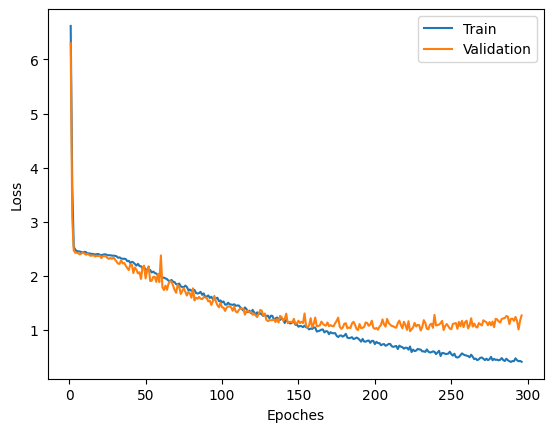

In [11]:
plotLoss(history)


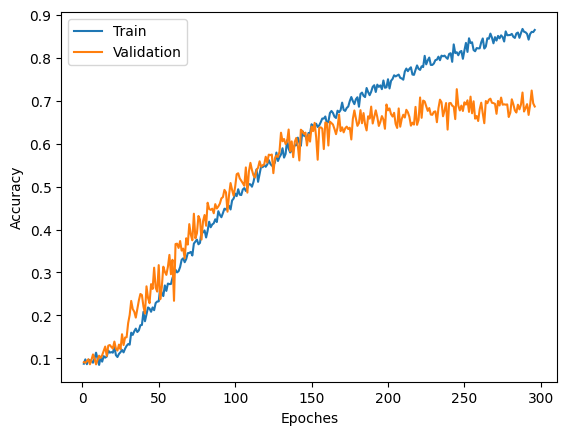

In [12]:
plotAcc(history)


## Testing


In [13]:
# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
bestdModel.eval()

# Initialize a list to store the predictions.
predictions = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    # But here the variable "labels" is useless since we do not have the ground-truth.
    # If printing out the labels, you will find that it is always 0.
    # This is because the wrapper (DatasetFolder) returns images and labels for each batch,
    # so we have to create fake labels to make it work normally.
    imgs, labels = batch

    # We don't need gradient in testing, and we don't even have labels to compute loss.
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
        logits = bestdModel(imgs.to(device))

    # Take the class with greatest logit as prediction and record it.
    predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())


  0%|          | 0/34 [00:00<?, ?it/s]

In [14]:
# Save predictions into the file.
with open("predict.csv", "w") as f:

    # The first row must be "Id, Category"
    f.write("Id,Category\n")

    # For the rest of the rows, each image id corresponds to a predicted class.
    for i, pred in enumerate(predictions):
        f.write(f"{i},{pred}\n")
